# Shapiro Diagram with normalized parameters
### Cythonized, RF current in linear & log scale

## CPR of $I(\phi)=[\sin(\phi)+\eta\sin(2\phi)]+A(\sin(\phi+C)+\eta\sin[2(\phi+C)])$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import *
from scipy.io import savemat
from scipy.integrate import odeint
%matplotlib inline

In [2]:
%load_ext Cython

### Resistively Shunted Model:

$\frac{d\phi}{dt}=\frac{2eR_N}{\hbar}[I_{DC}+I_{RF}\sin(2\pi f_{RF}t)-I_C\sin\phi]$

Solving $\phi(t)$, then you can get the voltage difference between the superconducting leads:

$V=\frac{\hbar}{2e}\langle\frac{d\phi}{dt}\rangle$

After Normalizing:
$I_{DC}\leftrightarrow \tilde{I_{DC}}=I_{DC}/I_C$,

$I_{RF} \leftrightarrow \tilde{I_{RF}}=I_{RF}/I_C$,

$ V \leftrightarrow \tilde{V}=\frac{V}{I_CR_N}$,

$ R=\frac{dV}{dI} \leftrightarrow \tilde{R}=\frac{R}{R_N}$,


$\because f_0=2eI_CR_N/h$,

$f_{RF} \leftrightarrow \tilde{f_{RF}}=f_{RF}/f_0$,

$t \leftrightarrow \tilde{t}=f_0t$,

The Josephson voltage quantized at $\frac{V}{hf_{RF}f_0/2e}=n \leftrightarrow \frac{V}{f_{RF}f_0}=n$ 

Here, we can set $f_0=1$ or $\frac{I_CR_N}{hf_0/2e}=1$, without loss of generality

The RSJ model simply becomes (omitting $\tilde{}$):

$\frac{d\phi}{dt}=[I_{DC}+I_{RF}\sin(2\pi f_{RF}t)-\sin\phi]$

At equilibrium, $V=\frac{\hbar}{2e}\langle\frac{d\phi}{dt}\rangle \leftrightarrow \tilde{V}=\frac{1}{2\pi}\langle\frac{d\phi}{d\tilde{t}}\rangle$  would also quantized at integers in the Shapiro step regime.



### Cython codes here is to speed up the simulation because python is slower than C:

In [3]:
%%cython  
#--pgo # only for Mac OS X
#To use GNU compiler gcc-10 specified in .bash_profile

cimport numpy as np
from libc.math cimport sin, pi

### cdef is faster but can only be used for cython in this cell
#cpdef can be used for python outside this cell

cdef double CPR(double G, double A, double eta, double C):
    '''
        Current-phase relationship for the junction
    '''
    return sin(G)+eta*sin(2*G)+A*sin(G+C*pi)+A*eta*sin(2*G+2*C*pi)

cpdef double dGdt(G,double t,double i_dc,double i_ac,double f_rf,double A, double eta, double C):
    '''
        RSJ model
    '''
    der =  i_dc + i_ac * sin(2*pi*f_rf*t) - CPR(G,A,eta,C)
    return der 

In [4]:
from scipy.optimize import fmin

In [5]:
def find_Ic_max(A,eta,C):
    Gmax=fmin(lambda x: -CPR(x,A,eta,C),0,disp=0)
    return CPR(Gmax,A,eta,C)

In [5]:
A=0.
eta=0.8
C=-0.7 # as a unit of pi
f_rf=0.8

In [128]:
IDC_step=0.1
IDC_array=np.linspace(-5,5,201)
IRF_step=0.1
IRF_array=np.linspace(0,15,151)

print("DC array size: "+str(len(IDC_array)))
print("RF array size: "+str(len(IRF_array)))



DC array size: 201
RF array size: 151


### Plot CPR

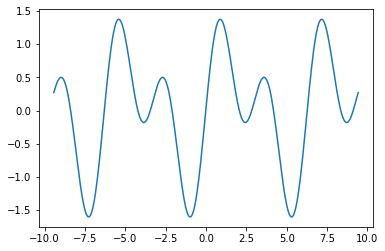

In [129]:
G=np.linspace(-3,3,301)*np.pi
def CPR(G, A, eta, C):
    return np.sin(G)+eta*np.sin(2*G)+A*np.sin(G+C*np.pi)+A*eta*np.sin(2*G+2*C*np.pi)
plt.figure()
plt.plot(G,CPR(G,A,eta,C))


### Test on a single RF current

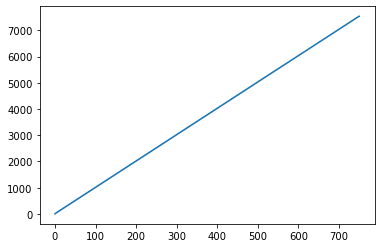

In [130]:
t=np.arange(0,300.01,0.01)/f_rf
V=np.empty([len(IDC_array)])
G_array=np.empty(len(t))
for i in range(0,len(IDC_array)):
    G_array= odeint(dGdt,0,t,args=(IDC_array[i],15,f_rf,A,eta,C))
    V[i]=np.mean(np.gradient(G_array[-10000:,0]))/(0.01/f_rf)/(2*np.pi)
DVDI=2*np.pi*np.gradient(V,IDC_step) #differential resistance dV/dI
plt.plot(t,G_array)
JV=f_rf

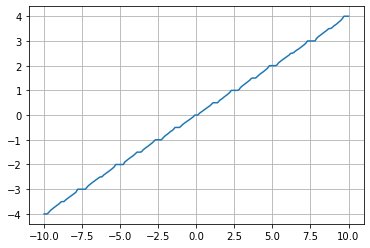

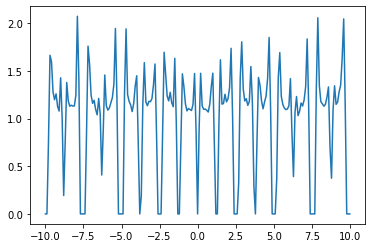

In [131]:
plt.figure()
plt.plot(IDC_array,V/JV)
plt.grid()
plt.figure()
plt.plot(IDC_array,DVDI)
#plt.ylim([0,3])

In [132]:
_name_file = "f_"+str(f_rf)+"_A"+str(np.round(A,3))+"_eta"+str(np.round(eta,3))+"_C"+str(np.round(C,2))+"pi_norm"
_name_title = "f= "+str(f_rf)+", A= "+str(np.round(A,3))+", eta= "+str(np.round(eta,3))+",C= "+str(np.round(C,2))+"pi"
print(_name_title)
T1=datetime.now()
print (T1)
V=np.empty([len(IRF_array),len(IDC_array)])
for i in range(0,len(IRF_array)):
    print("RF power now: "+str(i)+" of "+str(len(IRF_array))+" ,"+str(datetime.now()),end="\r")
    for j in range(0,len(IDC_array)):
        t=np.arange(0,300.01,0.01)/f_rf
        G_array= odeint(dGdt,0,t,args=(IDC_array[j],IRF_array[i],f_rf,A,eta,C))
        V[i,j]=np.mean(np.gradient(G_array[-10001:,0]))/(0.01/f_rf)/(2*np.pi)

DVDI=2*np.pi*np.gradient(V,IDC_step,axis=1)


print ("\n It takes " + str(datetime.now()-T1))                
        
plt.figure()
plt.pcolormesh(IDC_array, IRF_array, DVDI, cmap = 'inferno', vmin = 0,linewidth=0,rasterized=True,shading="auto")
plt.xlabel("DC Current($I/I_C$)")
plt.ylabel("RF Current ($I_RF/I_C$)")
plt.colorbar(label = "DV/DI")
plt.title(_name_title)
plt.savefig("DVDI_"+_name_file+".pdf")
plt.show()
                
plt.figure()
plt.pcolormesh(IDC_array, IRF_array, V/f_rf , cmap = 'coolwarm',linewidth=0,rasterized=True,shading="auto")
plt.xlabel("DC Current($I/I_C$)")
plt.ylabel("RF Current ($I_RF/I_C$)")
plt.colorbar(label = "$V/I_CR_N$")
plt.title(_name_title)
plt.savefig("V_"+_name_file+".pdf")
plt.show()

plt.figure()
plt.plot(IDC_array,V[1,:]/f_rf)#/(np.pi*hbar*f/Qe))
plt.show()
plt.figure()
plt.plot(IDC_array,DVDI[1,:])
plt.show()
savemat("data"+_name_file+'.mat',mdict={'IDC':IDC_array,'IRF':IRF_array,'A':A, 'eta':eta, 'f_rf':f_rf,'C':C,'V':V,'DVDI':DVDI})
print('file saved')

f= 0.4, A= 0.2, eta= 0.8,C= -0.8pi
2020-09-26 13:11:28.119589


KeyboardInterrupt: 

### Calculate the normalized frequency

In [6]:
Qe=1.602e-19
Ic=2e-6
Rn=13
h=6.626e-34
f0=2*Qe*Ic*Rn/h
print(5e9/f0)
print(2.5e9/f0)


0.3976999903966197
0.19884999519830984


## Simulation using log scales in power

In [16]:
A=0.6
eta=0.9
C=-0.9 # as a unit of pi
f_rf=0.8

In [7]:
IDC_step=0.05
IDC_array=np.linspace(-10,10,401)
PRF_step=0.02
PRF_array=np.linspace(-1.5,2.5,201)
IRF_array = 10**(PRF_array/2)
print(IRF_array[-1])
print(IRF_array[0])

print("DC array size: "+str(len(IDC_array)))
print("RF array size: "+str(len(IRF_array)))
print("DC step: "+str(IDC_array[1]-IDC_array[0]))
print("RF step: "+str(PRF_array[1]-PRF_array[0]))


17.78279410038923
0.1778279410038923
DC array size: 401
RF array size: 201
DC step: 0.05000000000000071
RF step: 0.020000000000000018


In [8]:
f_rf=0.4
A_array=np.array([0])
eta_array=np.array([0,0.9])
C_array=np.array([0])

f= 0.4, A= 0, eta= 0.0,C= 0pi
2020-10-09 21:07:10.133882

 It takes 0:37:48.851441


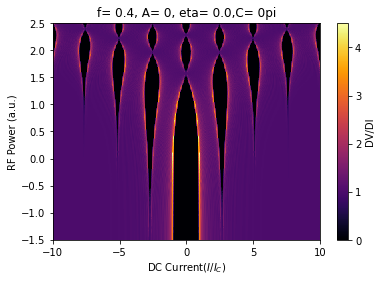

file saved
f= 0.4, A= 0, eta= 0.9,C= 0pi
2020-10-09 21:44:59.698081

 It takes 1:07:44.802932


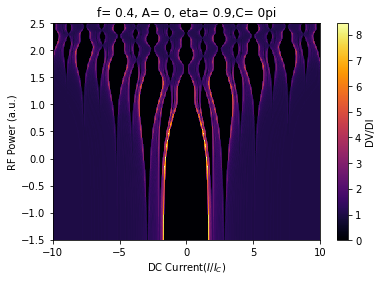

file saved


In [9]:
for A in A_array:
    for eta in eta_array:
        for C in C_array:

            _name_file = "f_"+str(f_rf)+"_A"+str(np.round(A,3))+"_eta"+str(np.round(eta,3))+"_C"+str(np.round(C,2))+"pi_log"
            _name_title = "f= "+str(f_rf)+", A= "+str(np.round(A,3))+", eta= "+str(np.round(eta,3))+",C= "+str(np.round(C,2))+"pi"
            print(_name_title)
            #Ic_max=find_Ic_max(A,eta,C)
            T1=datetime.now()
            print (T1)
            V=np.empty([len(IRF_array),len(IDC_array)])
            for i in range(0,len(IRF_array)):
                #print("RF power now: "+str(i)+" of "+str(len(IRF_array))+" ,"+str(datetime.now()),end="\r")
                for j in range(0,len(IDC_array)):
                    t=np.arange(0,300.01,0.01)/f_rf
                    G_array= odeint(dGdt,0,t,args=(IDC_array[j],IRF_array[i],f_rf,A,eta,C))
                    V[i,j]=np.mean(np.gradient(G_array[-10001:,0]))/(0.01/f_rf)/(2*np.pi)

            DVDI=2*np.pi*np.gradient(V,IDC_step,axis=1)


            print ("\n It takes " + str(datetime.now()-T1))                
        
            plt.figure()
            plt.pcolormesh(IDC_array, PRF_array, DVDI, cmap = 'inferno', vmin = 0,linewidth=0,rasterized=True,shading="auto")
            plt.xlabel("DC Current($I/I_C$)")
            plt.ylabel("RF Power (a.u.)")
            plt.colorbar(label = "DV/DI")
            plt.title(_name_title)
            plt.savefig("DVDI_"+_name_file+".pdf")
            plt.show()
                
            #plt.figure()
            #plt.pcolormesh(IDC_array, PRF_array, V/f_rf , cmap = 'coolwarm',linewidth=0,rasterized=True,shading="auto")
            #plt.xlabel("DC Current($I/I_C$)")
            #plt.ylabel("RF Power (a.u.)")
            #plt.colorbar(label = "$V/I_CR_N$")
            #plt.title(_name_title)
            #plt.savefig("V_"+_name_file+".pdf")
            #plt.show()

            #plt.figure()
            #plt.plot(IDC_array,V[len(IRF_array)//2,:]/f_rf)#/(np.pi*hbar*f/Qe))
            #plt.title("cut at power= "+str(PRF_array[len(IRF_array)//2]))
            #plt.show()
            #plt.figure()
            #plt.plot(IDC_array,DVDI[len(IRF_array)//2,:])
            #plt.title("cut at power= "+str(PRF_array[len(IRF_array)//2]))
            #plt.show()
            savemat("./data"+_name_file+'.mat',mdict={'IDC':IDC_array,'IRF':IRF_array,'PRF':PRF_array,'A':A, 'eta':eta, 'f_rf':f_rf,'C':C,'V':V,'DVDI':DVDI})#,'Ic_max':Ic_max})
            print('file saved')

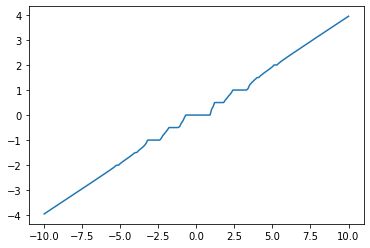

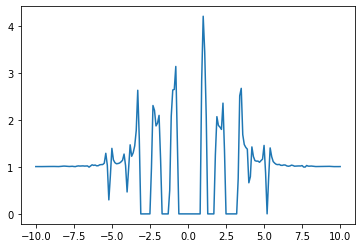

0.75


In [126]:
plt.figure()
plt.plot(IDC_array,V[130,:]/f_rf)#/(np.pi*hbar*f/Qe))
plt.show()
plt.figure()
plt.plot(IDC_array,DVDI[130,:])
plt.show()
print(PRF_array[130])

In [1]:
from scipy.io import loadmat

In [36]:
import sys
#sys.path.insert(0, 'C:/Users/QMDla/Documents/GitHub/data_file_manipulations/')
sys.path.insert(0, '/Volumes/GoogleDrive/My Drive/GitHub/data_file_manipulations/')
import files_manipulation

In [37]:
import importlib

In [38]:
importlib.reload(files_manipulation)

<module 'files_manipulation' from '/Volumes/GoogleDrive/My Drive/GitHub/data_file_manipulations/files_manipulation.py'>

In [39]:
dataDir = "./"
files_manipulation.merge_multiple_mat(dataDir,True) # True for saving .h5


IDC.shape=(201,)
IRF.shape=(201,)
PRF.shape=(201,)
A.shape=(4,)
eta.shape=(4,)
f_rf.shape=(4,)
C.shape=(4,)
V.shape=(201, 201, 4)
DVDI.shape=(201, 201, 4)


In [40]:
import h5py

In [41]:
fd= h5py.File('merged.h5','r')

In [42]:
list(fd.keys())

['A', 'C', 'DVDI', 'IDC', 'IRF', 'PRF', 'V', 'eta', 'f_rf']

In [43]:
A=fd['A'][...]
print(A.shape)
C=fd['C'][...]
print(C.shape)
DVDI=fd['DVDI'][...]
print(DVDI.shape)
IDC=fd['IDC'][...]
print(IDC.shape)
IRF=fd['IRF'][...]
print(IRF.shape)
PRF=fd['PRF'][...]
print(PRF.shape)
V=fd['V'][...]
print(V.shape)
eta=fd['eta'][...]
print(eta.shape)
f_rf=fd['f_rf'][...]
print(f_rf.shape)

(4,)
(4,)
(201, 201, 4)
(201,)
(201,)
(201,)
(201, 201, 4)
(4,)
(4,)


In [50]:
print(A)
print(eta)

[0.  0.2 0.8 0. ]
[0.9 0.9 0.9 0. ]


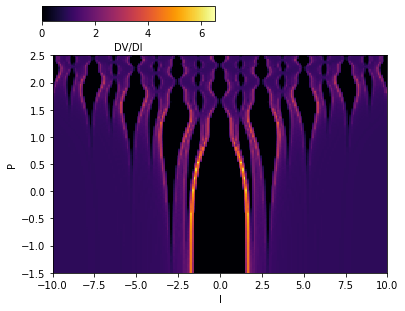

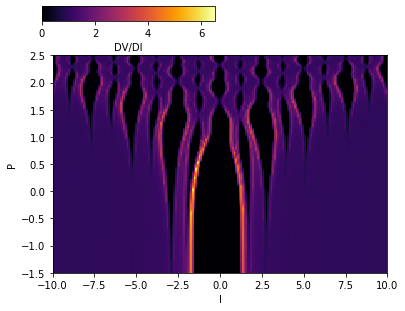

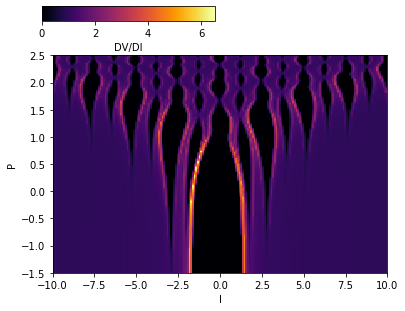

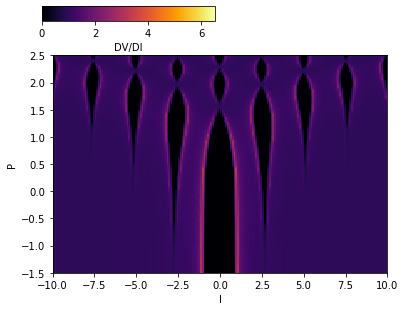

In [53]:
for i in range(0,4):
    fig=plt.figure()
    im=plt.pcolormesh(IDC, PRF, np.squeeze(DVDI[:,:,i]), cmap = 'inferno', vmin = 0,vmax=6.5,linewidth=0,rasterized=True,shading="auto")
    plt.xlabel("I")
    plt.xlim([-10,10])
    plt.ylim([-1.5,2.5])
    plt.ylabel("P")
    cbaxes = fig.add_axes([0.1, 1, 0.4, 0.05]) 
    cb=fig.colorbar(im, label = "DV/DI",orientation="horizontal",cax=cbaxes)
    
    plt.savefig("DVDI_eta"+str(eta[i])+"_A"+str(A[i])+".pdf",bbox_inches='tight')
    plt.show()
                